In [77]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [78]:
data = pd.read_csv("C:\\Users\\dakha\\Downloads\\Mall_Customers.csv")

In [79]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [80]:
print(f"Datast has {data.shape[0]} rows and {data.shape[1]} columns")

Datast has 200 rows and 5 columns


In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [82]:
# no need for customer ID, drop them
data = data.drop(['CustomerID'], axis = 1)
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [83]:
# import visualization tools 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
# import standardizer and one hot encoder to convert categorical data into numerical data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [85]:
columns = ["Annual Income (k$)", "Age", "Spending Score (1-100)"]
scaler = StandardScaler()

features = scaler.fit_transform(data[columns])
scaled_df = pd.DataFrame(features, columns=columns)
scaled_df.head()

,Annual Income (k$),Age,Spending Score (1-100)
0,-1.738999,-1.424569,-0.434801
1,-1.738999,-1.281035,1.195704
2,-1.700830,-1.352802,-1.715913
3,-1.700830,-1.137502,1.040418
4,-1.662660,-0.563369,-0.395980


In [86]:
one_hot_encoder = OneHotEncoder()
enc_df = pd.DataFrame(one_hot_encoder.fit_transform(data[['Gender']]).toarray(), columns=["Gender_1", "Gender_2"])

all_data = scaled_df.join(enc_df)
all_data.head()

,Annual Income (k$),Age,Spending Score (1-100),Gender_1,Gender_2
0,-1.738999,-1.424569,-0.434801,0.0,1.0
1,-1.738999,-1.281035,1.195704,0.0,1.0
2,-1.700830,-1.352802,-1.715913,1.0,0.0
3,-1.700830,-1.137502,1.040418,1.0,0.0
4,-1.662660,-0.563369,-0.395980,1.0,0.0


In [87]:
#check all the data type
all_data.dtypes

Annual Income (k$)        float64
Age                       float64
Spending Score (1-100)    float64
Gender_1                  float64
Gender_2                  float64
dtype: object

All is float

In [88]:
# lets start clustering 
from sklearn.cluster import KMeans

In [89]:
sse = {}

for k in range(1, 10):
    k_means = KMeans(n_clusters=k, init="k-means++", n_jobs=-1)
    k_means.fit(all_data)
    sse[k] = k_means.inertia_

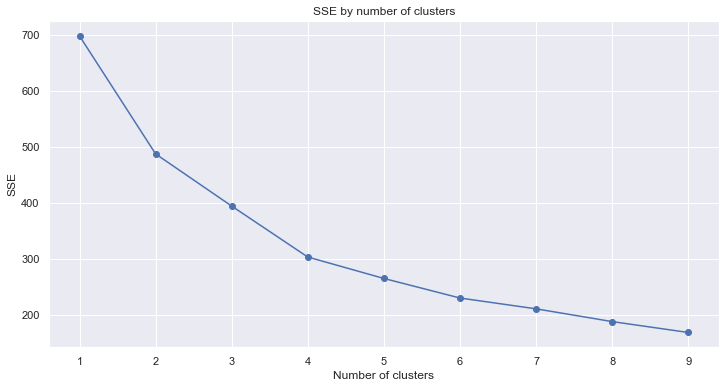

In [90]:
sns.set()

plt.figure(figsize=(12, 6))
keys = pd.DataFrame(sse.keys(), columns=["number of clusters"])
sse_values = pd.DataFrame(sse.values(), columns=["sse value"])

elbow_df = keys.join(sse_values)
plt.plot(elbow_df["number of clusters"], elbow_df["sse value"], marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("SSE by number of clusters");

Here we can see that ideal number of clusters is 4, 
let's compute the silouhette coefficient to check how good enough is our clustering

In [91]:
# to calculate Silhoutte score 
from sklearn.metrics import silhouette_score

In [92]:
k_means = KMeans(n_jobs=-1, n_clusters=4, init="k-means++")
k_means.fit(all_data)
a = silhouette_score(all_data, k_means.labels_, metric="euclidean")
print("The Silhoutte score for given data is",a)

The Silhoutte score for given data is 0.3194701864060389


In [93]:
clusters = k_means.fit_predict(data.iloc[:,1:])
data["cluster"] = clusters

No handles with labels found to put in legend.


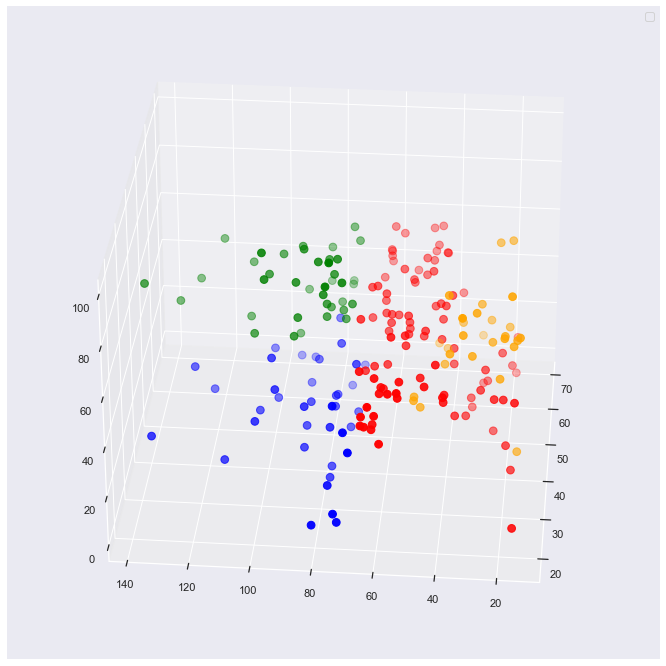

In [94]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(data.Age[data.cluster == 0], data["Annual Income (k$)"][data.cluster == 0], data["Spending Score (1-100)"][data.cluster == 0],
           c="blue", s=60)
ax.scatter(data.Age[data.cluster == 1], data["Annual Income (k$)"][data.cluster == 1], data["Spending Score (1-100)"][data.cluster == 1],
           c="red", s=60)
ax.scatter(data.Age[data.cluster == 2], data["Annual Income (k$)"][data.cluster == 2], data["Spending Score (1-100)"][data.cluster == 2],
           c="green", s=60)
ax.scatter(data.Age[data.cluster == 3], data["Annual Income (k$)"][data.cluster == 3], data["Spending Score (1-100)"][data.cluster == 3],
           c="orange", s=60)

ax.view_init(30, 185)
ax.legend()
plt.show()

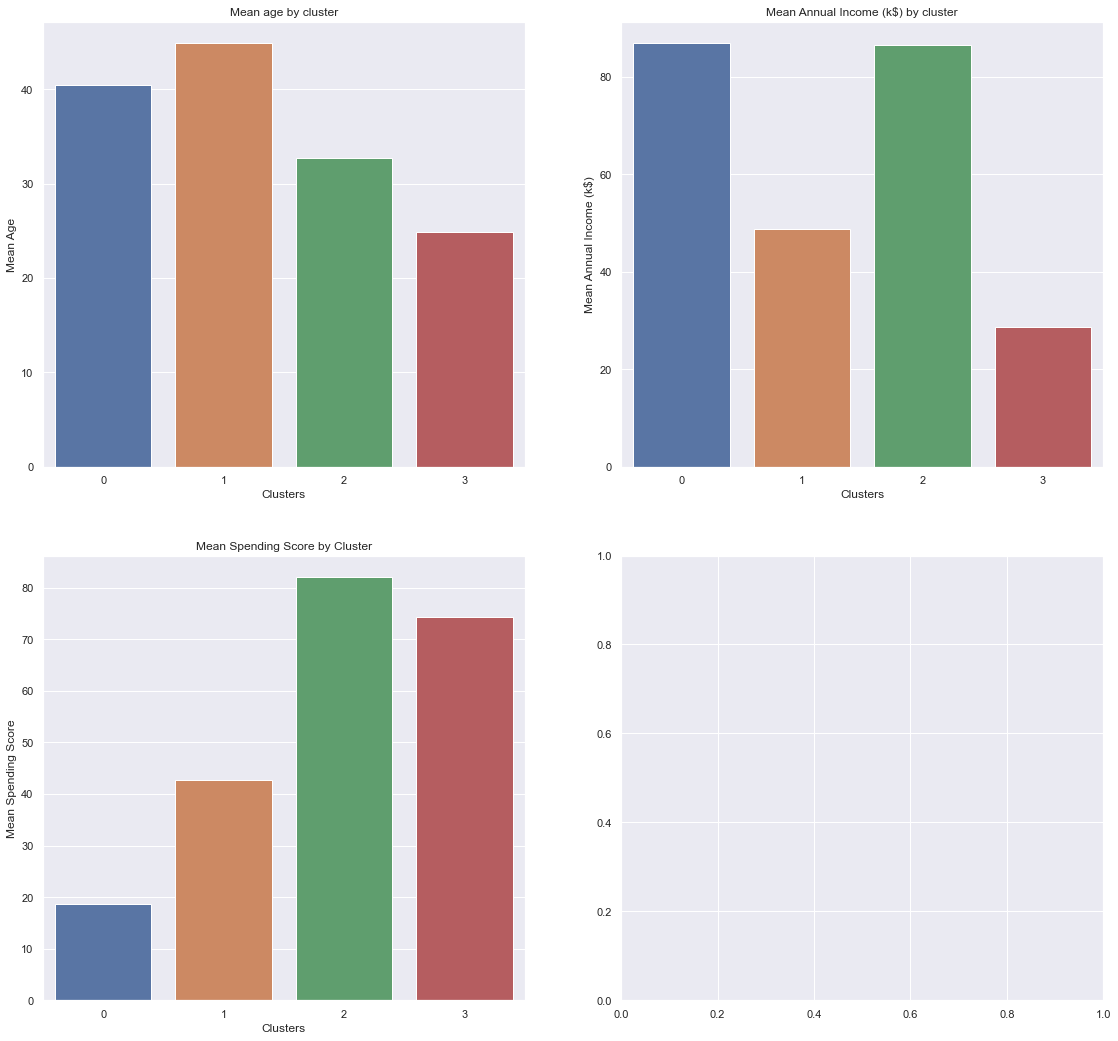

In [95]:
figure, axes = plt.subplots(2, 2, figsize=(19, 18))


cluster_age = data.groupby("cluster")["Age"].mean().sort_values(ascending=False)
cluster_annual_income = data.groupby("cluster")["Annual Income (k$)"].mean().sort_values(ascending=False)
cluster_spending_score = data.groupby("cluster")["Spending Score (1-100)"].mean().sort_values(ascending=False)


sns.barplot(x=cluster_age.index, y=cluster_age.values, ax=axes[0, 0])
axes[0, 0].set_xlabel("Clusters")
axes[0, 0].set_ylabel("Mean Age")
axes[0, 0].set_title("Mean age by cluster")


sns.barplot(x=cluster_annual_income.index, y=cluster_annual_income.values, ax=axes[0, 1])
axes[0, 1].set_xlabel("Clusters")
axes[0, 1].set_ylabel("Mean Annual Income (k$)")
axes[0, 1].set_title("Mean Annual Income (k$) by cluster")


sns.barplot(x=cluster_spending_score.index, y=cluster_spending_score.values, ax=axes[1, 0])
axes[1, 0].set_xlabel("Clusters")
axes[1, 0].set_ylabel("Mean Spending Score")
axes[1, 0].set_title("Mean Spending Score by Cluster");

Cluster 0 is a group of people in their 40s, what's interesting is that they have a good income but they tend to spend very little, maybe we could incenticise those people with targeted marketing compains to build customer loyalty and propose interesting products regarding their interests.

Cluster 2 contains young customers as well probably students or junior employees. They have a small revenue but spend quite some. We may be interested to target those clients with coupons or offers to build up customer loyalty.

Cluster 3 contains young customers in ealy 30s of age, with a high revenue and have a very interesting spending profile. Those are the clients that we don't wanna lose.